In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne

from gait_modulation.file_reader import MatFileReader
from gait_modulation.data_processor import DataProcessor


# Loading the data

In [2]:
# Use this class to handle multiple patients with nested directories.

root_directory = '/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data'
mat_reader = MatFileReader(root_directory, max_workers=1)  # You can adjust the number of workers for parallelism

# Read all data from nested folders of multiple patients and trials
all_data = mat_reader.read_data()
len(all_data)

Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_HK59/26_10_22/walking_sync_2_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_HK59/26_10_22/walking_sync_3_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_4_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_2_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_3_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/mast

16

In [3]:
# Access specific sessions for a patient
session = all_data[0]

In [4]:
# extract events and imu data of the subject/session
imu_data = session['data_acc']
imu_metadata = DataProcessor.np_to_dict(session['hdr_IMU'])
events_KIN = DataProcessor.np_to_dict(session['events_KIN'])

imu_data.shape, imu_metadata, session.keys()

((15, 50081),
 {'Fs': array([[128]], dtype=uint8),
  'label': array([[array(['Right Wrist'], dtype='<U24'),
          array(['Right Foot'], dtype='<U24'),
          array(['Left wrist'], dtype='<U24'),
          array(['Left foot'], dtype='<U24'),
          array(['Sternum'], dtype='<U24')]], dtype=object)},
 dict_keys(['data_acc', 'data_EEG', 'data_EMG', 'data_giro', 'data_LFP', 'dir', 'events_KIN', 'events_STEPS', 'filename_mat', 'hdr_EEG', 'hdr_EMG', 'hdr_IMU', 'hdr_LFP', 'pt', 'session']))

In [5]:
imu_metadata['label'].squeeze()

array([array(['Right Wrist'], dtype='<U24'),
       array(['Right Foot'], dtype='<U24'),
       array(['Left wrist'], dtype='<U24'),
       array(['Left foot'], dtype='<U24'),
       array(['Sternum'], dtype='<U24')], dtype=object)

In [6]:
# Load parameters
imu_sfreq = imu_metadata['Fs'].item()
imu_ch_names = imu_metadata['label'].squeeze()

# Create 15 labels by combining each original label with the three axes
imu_labels = [label[0] for label in imu_metadata['label'][0]]
axes = ['x', 'y', 'z']
imu_labels = [f'{label} {axis}' for label in imu_labels for axis in axes]
imu_nlabels = len(imu_labels)

imu_duration = imu_data.shape[1] / imu_sfreq
n_samples = int(imu_duration * imu_sfreq) # TODO: Trim the data

imu_data.shape, imu_labels, imu_duration, imu_sfreq, n_samples

((15, 50081),
 ['Right Wrist x',
  'Right Wrist y',
  'Right Wrist z',
  'Right Foot x',
  'Right Foot y',
  'Right Foot z',
  'Left wrist x',
  'Left wrist y',
  'Left wrist z',
  'Left foot x',
  'Left foot y',
  'Left foot z',
  'Sternum x',
  'Sternum y',
  'Sternum z'],
 391.2578125,
 128,
 50081)

Creating RawArray with float64 data, n_channels=15, n_times=50081
    Range : 0 ... 50080 =      0.000 ...   391.250 secs
Ready.
Using matplotlib as 2D backend.


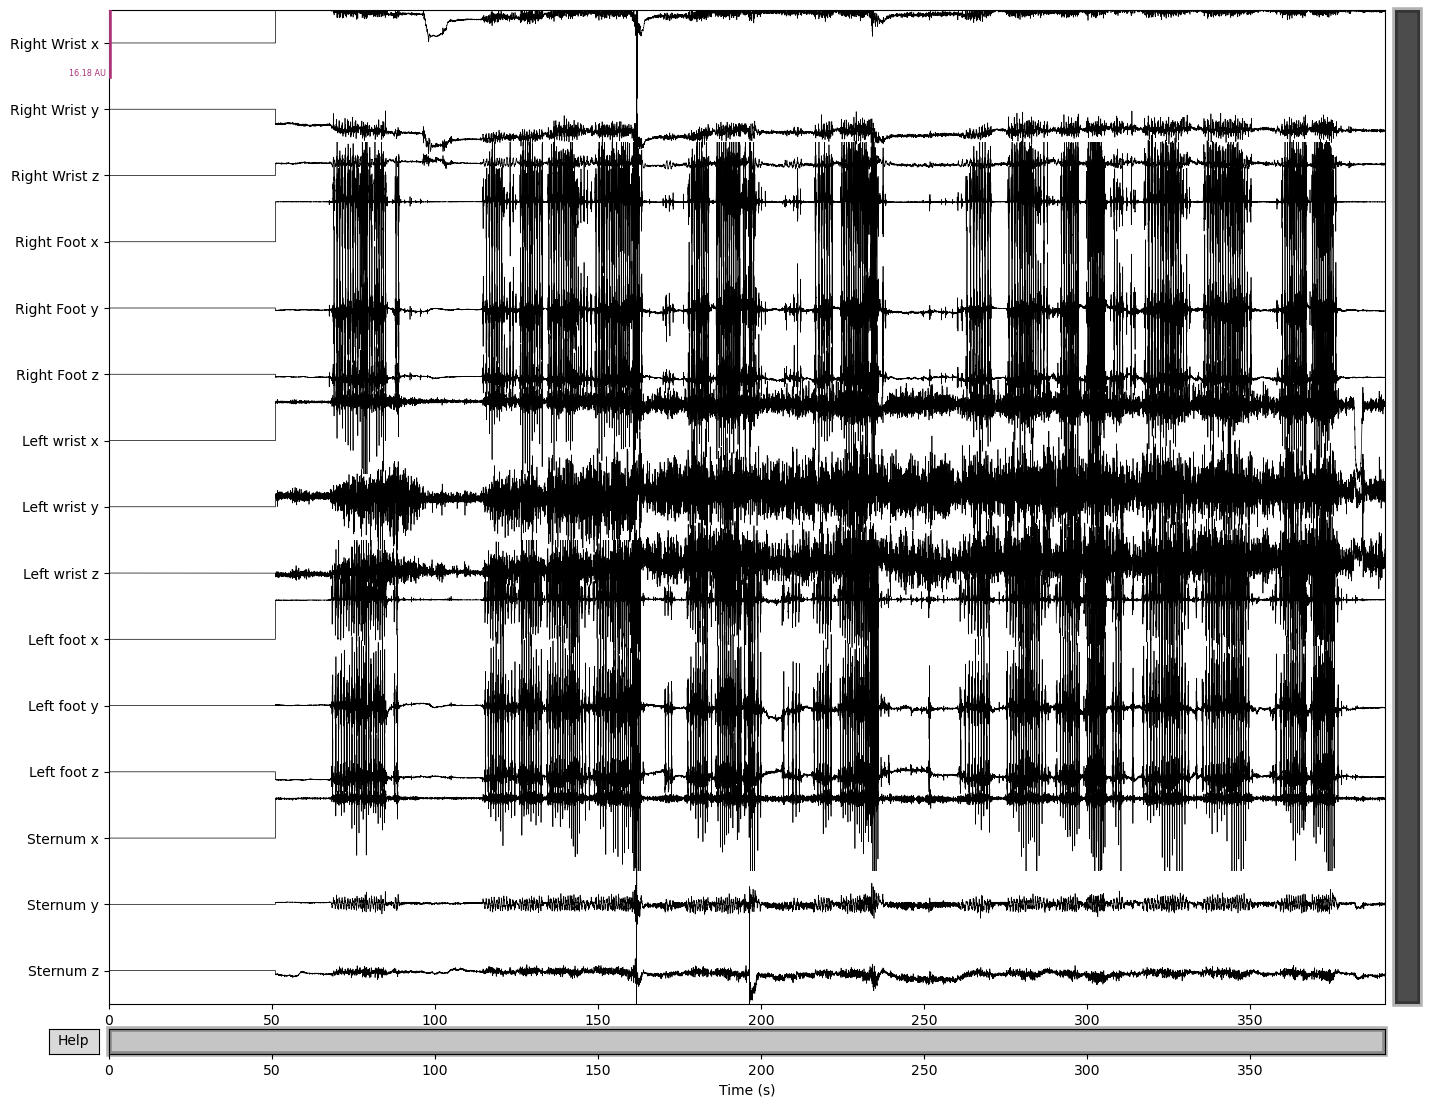

In [7]:
info = mne.create_info(ch_names=imu_labels, sfreq=imu_sfreq, ch_types='misc')
imu_raw = mne.io.RawArray(imu_data, info)
imu_raw.plot(start=0, duration=np.inf, remove_dc=False)
plt.show();

# Handle events

In [8]:
events, event_dict = DataProcessor.create_events_array(events_KIN, imu_sfreq)
# events

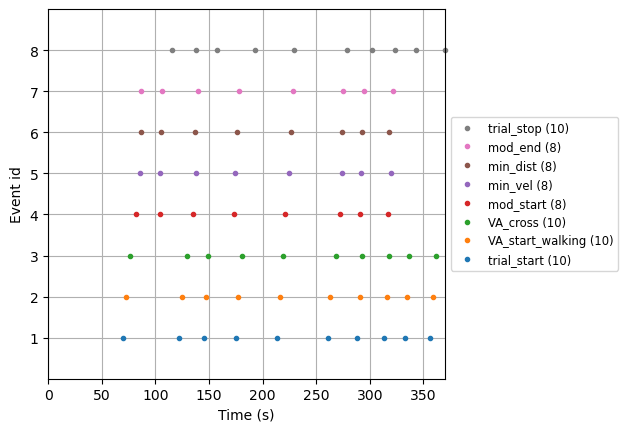

In [9]:
# mne.viz.plot_events(events, event_id=event_dict)
mne.viz.plot_events(events, sfreq=imu_sfreq, event_id=event_dict)
plt.show()

In [10]:
# Trim the data and adjusts the event onsets accordingly!
lfp_data, events = DataProcessor.trim_data(imu_data, events, imu_sfreq)

Number of samples removed: 6542
Number of seconds removed: 51.11 seconds


Creating RawArray with float64 data, n_channels=15, n_times=43539
    Range : 0 ... 43538 =      0.000 ...   340.141 secs
Ready.


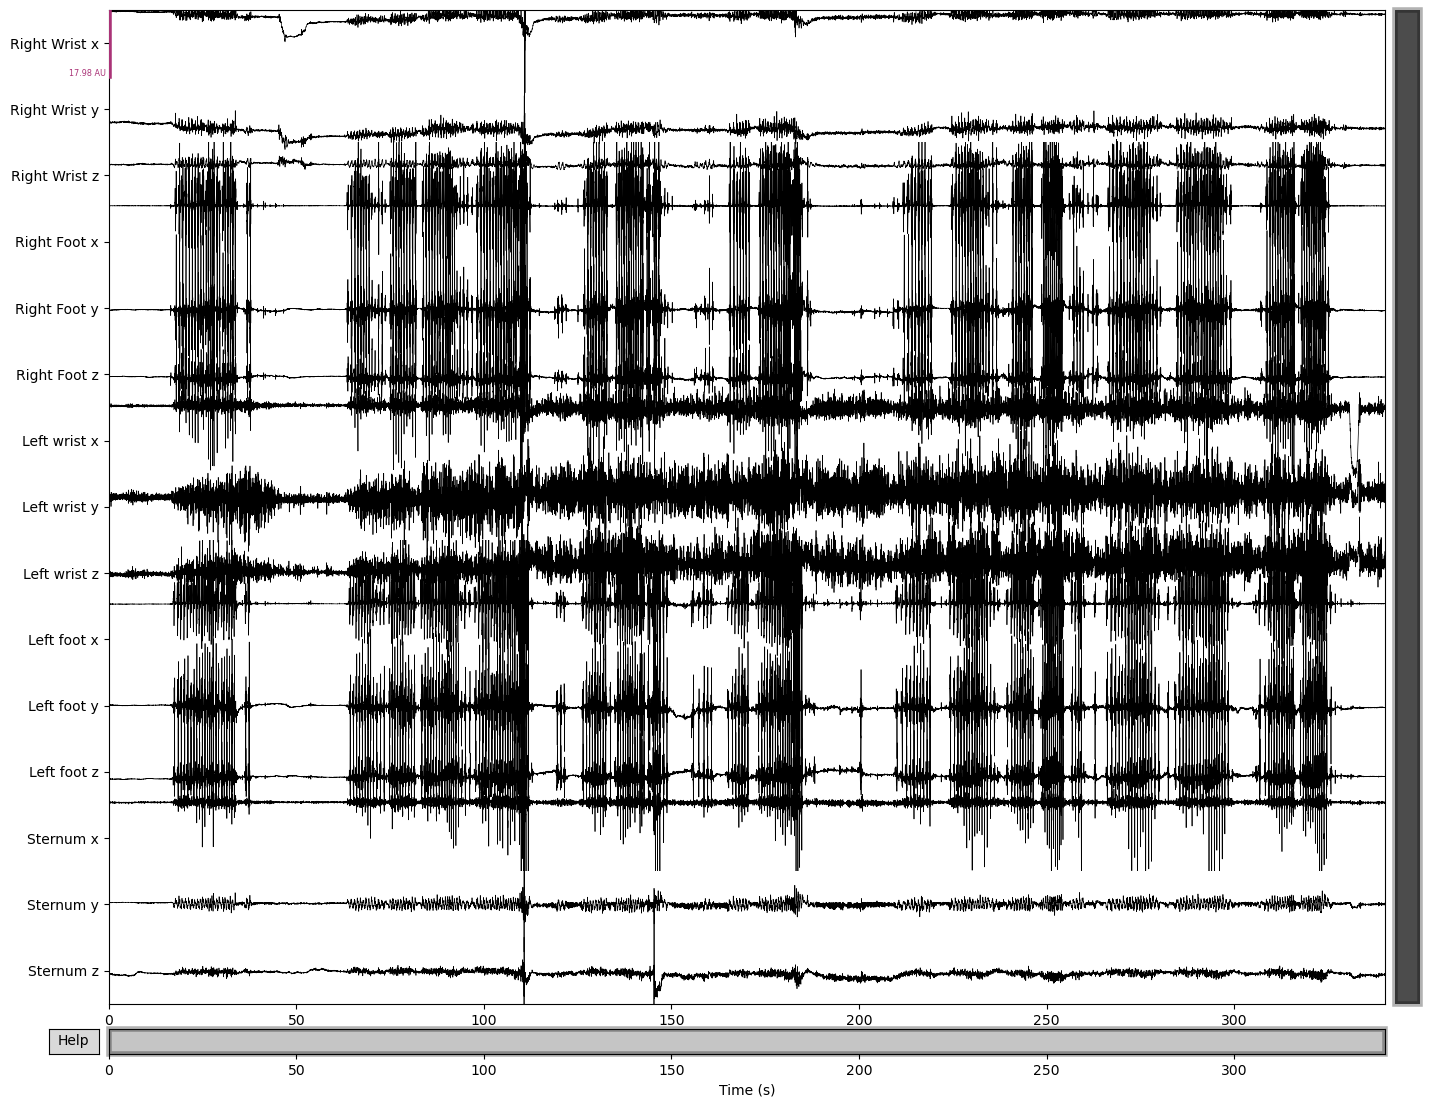

In [11]:
lfp_raw = mne.io.RawArray(lfp_data, info)
lfp_raw.plot(start=0, duration=np.inf, remove_dc=False)
plt.show()

## Extract the event-related

In [12]:
# Select one event to work with: mod_start
event_of_interest = 'mod_start'
events_mod_start = events[events[:, 2] == event_dict[event_of_interest]]

# Rename Gait Modulation Events
gait_modulation_event_id = 1
events_mod_start[:,2] = gait_modulation_event_id

In [13]:
# test the shape of the events
not_nans = np.count_nonzero(~np.isnan(events_KIN['times']))
nans = np.count_nonzero(np.isnan(events_KIN['times'])) 
flatten = events_KIN['times'].flatten().shape[0]

print(not_nans, nans, not_nans + nans, flatten)
print(events.shape)

72 8 80 80
(72, 3)


### Define Normal Walking Events
1. Extract Epochs Around Modulation Events: First, extract epochs centered around modulation events to ensure we capture relevant data around these events.
   
2.	Remove Invalid Gaps: After extracting epochs around modulation events, filter out epochs that are within invalid gaps (less than 10 seconds between modulation epochs and normal walking epochs).

3.	Assign Resting Data to Normal Walking Epochs: Use the remaining periods to extract normal walking epochs that are valid and not too close to modulation events.

In [14]:
# Define parameters
epoch_tmin = -2.0
epoch_tmax = 0.0
epoch_duration_length = epoch_tmax - epoch_tmin
epoch_sample_length = int(epoch_duration_length * imu_sfreq)
gap_duration = 10   # At least 10 seconds away from modulation events
gap_sample_length = int(gap_duration * imu_sfreq)
# n_samples = lfp_data.shape[1]

In [15]:
# Define Normal Walking Events
# Calculate gap boundaries (before and after each modulation event)
gap_boundaries = np.column_stack(
    (events_mod_start[:, 0] - gap_sample_length,
     events_mod_start[:, 0] + gap_sample_length)
)

# Construct the output array
normal_walking_ranges = np.vstack((
    np.array([500, gap_boundaries[0, 0]]),  # First interval
    np.column_stack((gap_boundaries[:-1, 1], gap_boundaries[1:, 0])),  # Middle intervals
    np.array([gap_boundaries[-1, 1], n_samples])  # Last interval
))

# Make sure that we don't generate events in the gap areas.
# Create a boolean mask where first column <= second column
mask = normal_walking_ranges[:, 0] <= normal_walking_ranges[:, 1]

# Apply the mask to remove rows where the first column > second column
normal_walking_ranges = normal_walking_ranges[mask]

walking_onsets = np.concatenate(
    [np.arange(boundary[0], boundary[1] + epoch_sample_length, epoch_sample_length) for boundary in normal_walking_ranges]
)

# Create the normal walking event array
normal_walking_event_id = -1
normal_walking_events = np.column_stack((
    walking_onsets.astype(int),
    np.zeros_like(walking_onsets, dtype=int),
    np.ones_like(walking_onsets, dtype=int) * normal_walking_event_id))

In [16]:
# Combine modulation and normal walking events
events = np.vstack((events_mod_start, normal_walking_events))
events = events[np.argsort(events[:, 0])]  # Sort events by onset time
event_dict = {'mod_start': gait_modulation_event_id,
            'normal_walking': normal_walking_event_id}

# Create Epochs
epochs = mne.Epochs(
    imu_raw,
    events,
    event_dict,
    epoch_tmin,
    epoch_tmax,
    baseline=None,
    preload=True,
)

# Print some details
print(f"Epochs info: {epochs}")
print(f"Number of epochs: {len(epochs)}")

Not setting metadata
135 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 135 events and 257 original time points ...
1 bad epochs dropped
Epochs info: <Epochs |  134 events (all good), -2 – 0 s, baseline off, ~4.0 MB, data loaded,
 'mod_start': 8
 'normal_walking': 126>
Number of epochs: 134


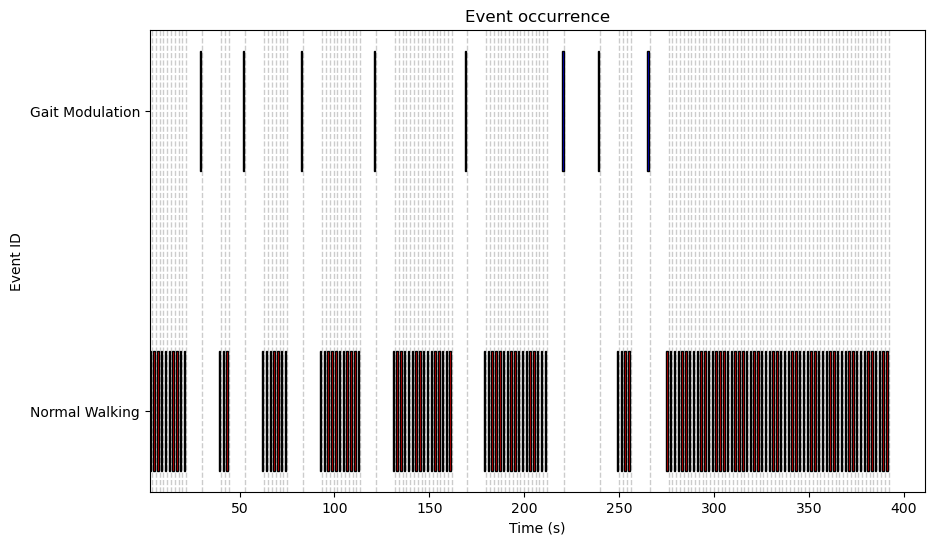

In [17]:
# Parameters for plotting
events_time = events[:, 0] / imu_sfreq
event_ids = events[:, 2]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
for onset, event_id in zip(events_time, event_ids):
    start = onset - epoch_sample_length/1000  # 500 ms before the onset
    end = onset
    color = 'blue' if event_id == gait_modulation_event_id else 'red'
    ax.barh(event_id, width=3*(end - start), left=start-1, color=color, edgecolor='black')

# Plot dashed lines for onsets
for onset in events_time:
    ax.axvline(x=onset, color='black', linestyle='--', linewidth=1,  alpha=0.2)

# Configure plot
ax.set_xlabel('Time (s)')
ax.set_ylabel('Event ID')
ax.set_yticks([gait_modulation_event_id, normal_walking_event_id])
ax.set_yticklabels(['Gait Modulation', 'Normal Walking'])
ax.set_title('Event occurrence')
plt.show()

In [18]:
epoch_colors = [['blue' if label == -1 else 'red'] * imu_nlabels for label in epochs[18:].events[:, 2]]

# Create a list of colors for each epoch, repeated for each channel
len(epoch_colors)


116

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


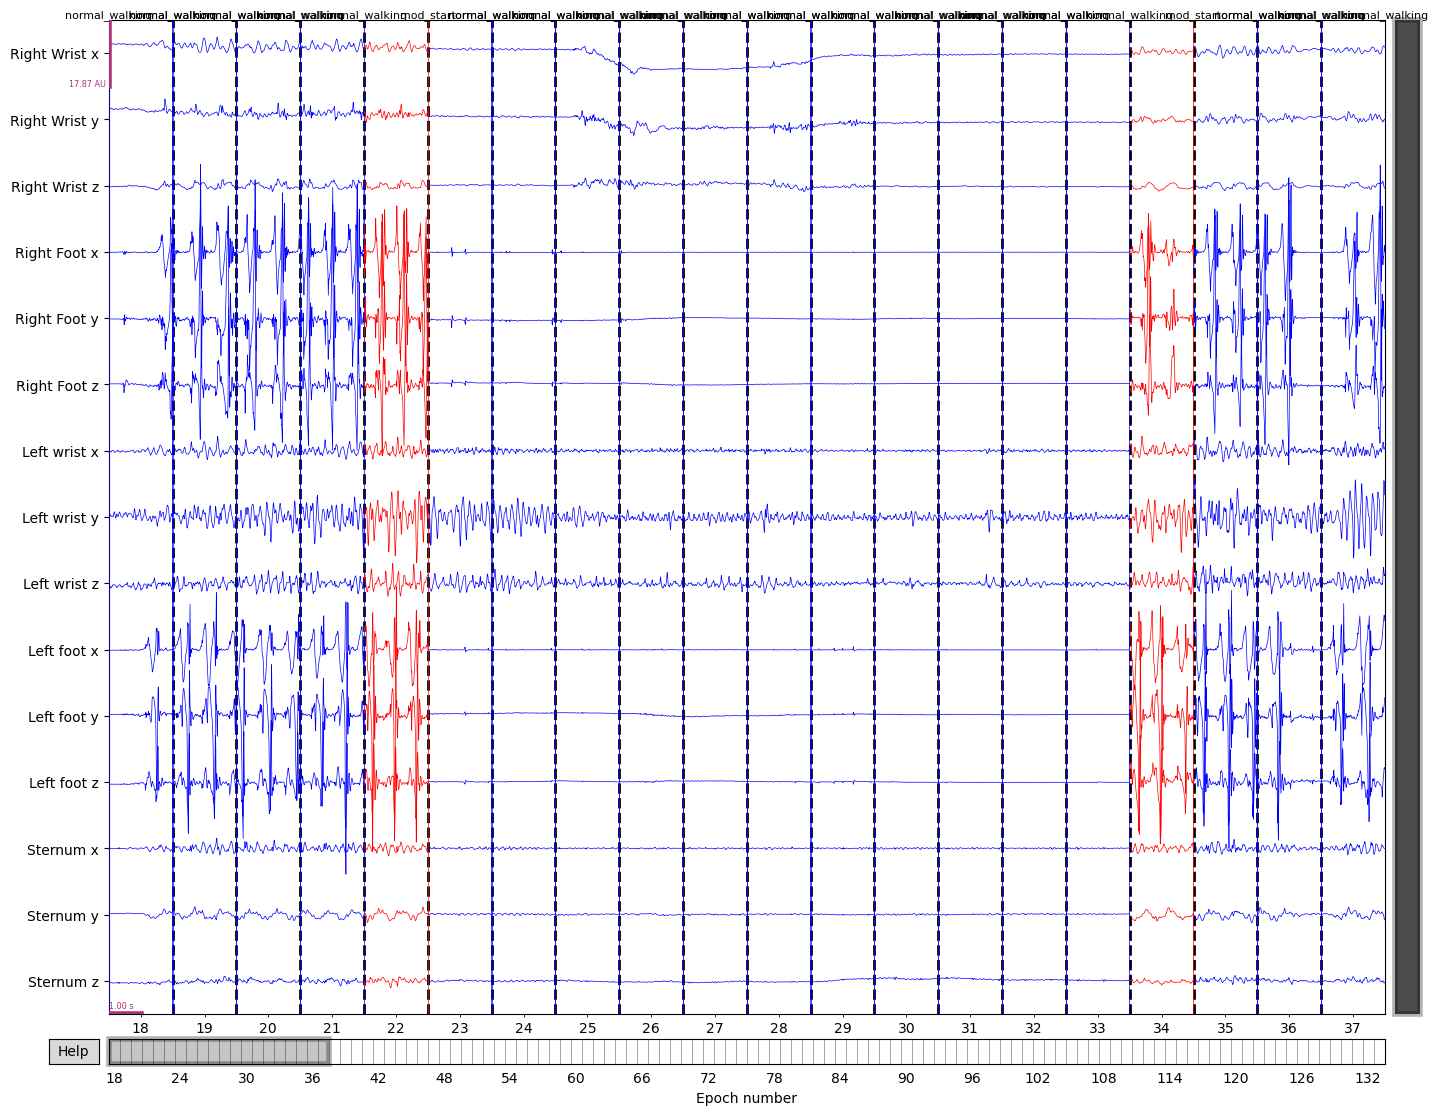

In [19]:
epochs[18:].plot(
    events=events,
    picks='all',  
    epoch_colors=epoch_colors,
    event_id=epochs.event_id,
    event_color=dict(mod_start="red", normal_walking="blue"),
)
plt.show();